<h1>Welcome to my Custom Neural Network</h1>

This Neural Network is built using a combination of NumPy, JAX and Pandas.

This program was inspired by Aadil Mallick's Medium Article found here:
https://medium.com/@waadlingaadil/learn-to-build-a-neural-network-from-scratch-yes-really-cac4ca457efc

The Neural Network is a basic feed-forward neural network that allows a customizable numbers of hidden layers, nodes per hidden layer, epochs, and a learning rate.

This model only works on BINARY classification problems by using the sigmoid function and rounding predictions to the nearest integer (0 or 1).

The following example utilizes a small dataset consisting of customer purchasing patterns and behavior.

To start, Import Required Libraries

In [13]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad
import jax.random as random
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

Load and Prepare Dataset for Model Ingestion.

In this case I found a dataset with customer purchasing information which can be used to model whether information about a customer indicates whether they are more likely to buy a product or not.

Data attained from Kaggle. Link to data here: https://www.kaggle.com/datasets/rabieelkharoua/predict-customer-purchase-behavior-dataset

In [14]:
#Load data and Preprocess

file_path = './customer_purchase_data.csv'
df = pd.read_csv(file_path)
# print(df.shape)
X, y = df.iloc[:,1:-1], df.iloc[:,-1]

In [15]:
#Split and scale data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=521996, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = jnp.array(scaler.fit_transform(X_train))
X_test_scaled = jnp.array(scaler.transform(X_test))
y_train = jnp.array(y_train.astype(float))
y_test = jnp.array(y_test.astype(float))

The Neural Network will be defined as a class that has two methods:

1) train, which trains the model with training data.
2) query, which makes predictions with data provided.

In [16]:
#Binary NN with Configurable Output
class BinFFNN():
  def __init__(self, hl=(3,3), epochs=1000, learning_rate=0.5, verbose=False):
    self.hl, self.epochs, self.learning_rate, self.Ws, self.bs, self.verbose = hl, epochs, learning_rate, [], [], verbose
  
  def train(self,X,y):
    # assert X.shape[0] == y.shape[0], "Number of rows for X and y data don't match"
    # assert y.ndim == 2, "y should have two dimensions"
    # assert y.shape[1] == 1, "Must reshape y to have two dimensions with second dimension of 1"

    Zs, As, dloss_dw_func, dloss_db_func = [],[X.T.copy()],[],[]

    #Sigmoid Function
    def sigmoid(x):
      return 1 / (1+jnp.exp(-x))

    #Initialize Weights and Biases
    key = random.PRNGKey(1000)
    for i in range(len(self.hl) + 1):
      if i == 0:
        self.Ws.append(random.normal(key,shape=(self.hl[i],X.shape[1])))
        self.bs.append(random.normal(key, shape=(self.hl[i],1)))
      elif i == max(range(len(self.hl) + 1)):
        self.Ws.append(random.normal(key, shape=(1,self.hl[i-1])))
        self.bs.append(random.normal(key, shape=(1,1)))
      else:
        self.Ws.append(random.normal(key, shape=(self.hl[i],self.hl[i-1])))
        self.bs.append(random.normal(key, shape=(self.hl[i],1)))

    #2. Do the feed forward process for each training sample.
    def get_A0(X):
      return X.T.copy()

    def get_Z(W1, A0, b1):
      return jnp.matmul(W1,A0) + b1
    
    def bcel(y_hat, y):
      return jnp.sum(-((y * jnp.log(y_hat)) + ((1-y)*jnp.log(1-y_hat))))/y_hat.shape[0]

    def feed_forward(X,y,*args):
      mid_point = len(args)//2
      Ws, bs, A = args[:mid_point], args[mid_point:], X.T.copy()
      for i in range(mid_point):
        Z = get_Z(args[i], A, args[i+mid_point])
        A = sigmoid(Z)
      y_hat = A.copy().flatten()
      loss = bcel(y_hat, y)
      # print("LOSS: ", loss)
      return loss

    mid_point, bind = len(self.Ws), self.Ws + self.bs
    for i in range(mid_point):
      dloss_dw_func.append(grad(lambda *bind: jnp.sum(feed_forward(X,y,*bind)), argnums=i))
      dloss_db_func.append(grad(lambda *bind: jnp.sum(feed_forward(X,y,*bind)), argnums=i+mid_point))
    
    losses = []
    if self.verbose:
      for j in tqdm(range(self.epochs)):
        bind = self.Ws + self.bs
        mid_point = len(bind) // 2
        losses.append(feed_forward(X,y,*bind))
        # print(feed_forward(X,y,*bind))
        for i in range(len(bind)):
          if i < mid_point: self.Ws[i] = self.Ws[i] - self.learning_rate*dloss_dw_func[i](*bind)
          if i >= mid_point: self.bs[i-mid_point] = self.bs[i-mid_point] - self.learning_rate*dloss_db_func[i-mid_point](*bind)
      plt.plot(losses)
      plt.title("Training Loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.show()
    else:
      for j in range(self.epochs):
        bind = self.Ws + self.bs
        mid_point = len(bind) // 2
        losses.append(feed_forward(X,y,*bind))
        # print(feed_forward(X,y,*bind))
        for i in range(len(bind)):
          if i < mid_point: self.Ws[i] = self.Ws[i] - self.learning_rate*dloss_dw_func[i](*bind)
          if i >= mid_point: self.bs[i-mid_point] = self.bs[i-mid_point] - self.learning_rate*dloss_db_func[i-mid_point](*bind)
    
  def query(self, X):
    for i in range(len(self.Ws)):
      if i == 0: A = X.T.copy()
      Z = jnp.matmul(self.Ws[i], A) +  self.bs[i]
      A = 1 / (1 + jnp.exp(-Z))
    y_hat = np.round(A.copy().flatten(),decimals=0)
    return y_hat

In this example, we'll evaluate three different models:

1) Neural Network
2) Logistic Regression
3) K-Nearest Neighbors

100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


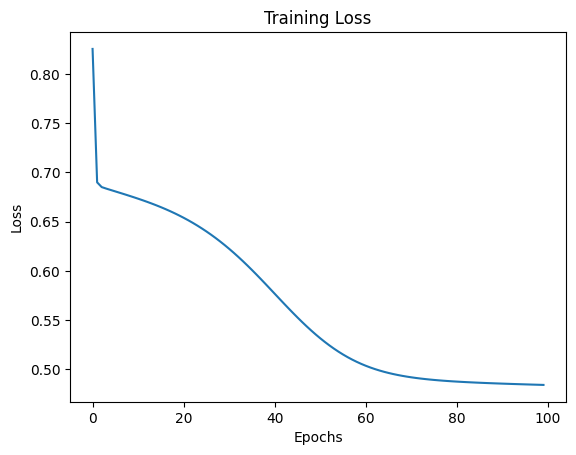

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [17]:
nn_cc = BinFFNN(hl=(3,3),epochs=100, learning_rate=2, verbose=True)
nn_cc.train(X_train_scaled, y_train)
lgr = LogisticRegression(max_iter=10000)
lgr.fit(X_train_scaled, y_train)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

Depending on the number of epochs used and what kind of hardware one has, the training can take a long time!

With Tensors and GPUs, this training time can be dramatically reduced and allow for more complex neural networks. Libraries like PyTorch and TensorFlow incorporate efficient methods for training, even without GPUs and are recommended to be leveraged in more advanced settings.

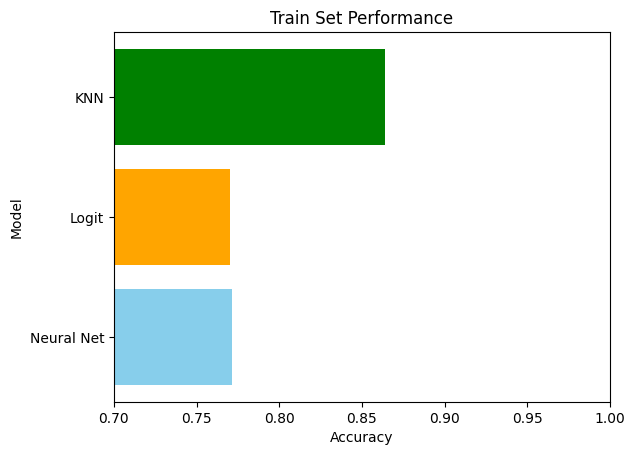

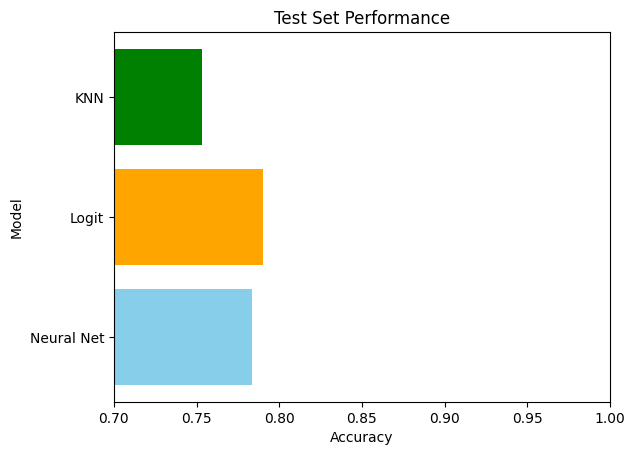

===TRAIN SET PERFORMANCE===
NN:  [[553 154]
 [120 373]] 0.7716666666666666
493.0
Logit:  [[549 152]
 [124 375]] 0.77
KNN:  [[604  94]
 [ 69 433]] 0.8641666666666666

===TEST SET PERFORMANCE===
NN:  [[146  32]
 [ 33  89]] 0.7833333333333333
Logit:  [[148  32]
 [ 31  89]] 0.79
KNN:  [[148  43]
 [ 31  78]] 0.7533333333333333


In [18]:
y_pred_train = nn_cc.query(X_train_scaled)
y_pred_test = nn_cc.query(X_test_scaled)
lgr_y_pred_train = lgr.predict(X_train_scaled)
lgr_y_pred_test = lgr.predict(X_test_scaled)
knn_y_pred_train = knn.predict(X_train_scaled)
knn_y_pred_test = knn.predict(X_test_scaled)

plt.barh(['Neural Net', 'Logit', 'KNN'],[accuracy_score(y_pred_train, y_train), accuracy_score(lgr_y_pred_train,y_train), accuracy_score(knn_y_pred_train, y_train)], color=['skyblue','orange','green'])
plt.title('Train Set Performance')
plt.xlim([0.7,1])
plt.xlabel('Accuracy')
plt.ylabel("Model")
plt.show()
plt.close()

plt.barh(['Neural Net', 'Logit', 'KNN'],[accuracy_score(y_pred_test, y_test), accuracy_score(lgr_y_pred_test,y_test), accuracy_score(knn_y_pred_test, y_test)], color=['skyblue','orange','green'])
plt.title('Test Set Performance')
plt.xlim([0.7,1])
plt.xlabel('Accuracy')
plt.ylabel("Model")
plt.show()
plt.close()

print("===TRAIN SET PERFORMANCE===")
print("NN: ", confusion_matrix(y_pred_train, y_train), accuracy_score(y_pred_train, y_train))
print(np.sum(y_pred_train))
print("Logit: ", confusion_matrix(lgr_y_pred_train, y_train), accuracy_score(lgr_y_pred_train, y_train))
print("KNN: ", confusion_matrix(knn_y_pred_train, y_train), accuracy_score(knn_y_pred_train, y_train))
print()
print("===TEST SET PERFORMANCE===")
print("NN: ", confusion_matrix(y_pred_test, y_test), accuracy_score(y_pred_test, y_test))
print("Logit: ", confusion_matrix(lgr_y_pred_test, y_test), accuracy_score(lgr_y_pred_test, y_test))
print("KNN: ", confusion_matrix(knn_y_pred_test, y_test), accuracy_score(knn_y_pred_test, y_test))

In [19]:
model = keras.Sequential([
    layers.Dense(3, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(3, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

custom_optmzr = Adam(learning_rate=2.0)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(tf.convert_to_tensor(X_train_scaled), tf.convert_to_tensor(y_train), epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])
probabilities_train =  model.predict(tf.convert_to_tensor(X_train_scaled))
probabilities = model.predict(tf.convert_to_tensor(X_test_scaled))
y_pred = (probabilities > 0.5).astype(int)
y_pred_train = (probabilities_train > 0.5).astype(int)
print("===TRAIN SET ACCURACY===")
print(confusion_matrix(y_pred_train, y_train), accuracy_score(y_pred_train, y_train))
print()
print("===TEST SET ACCURACY===")
print(confusion_matrix(y_pred, y_test), accuracy_score(y_pred, y_test))

c:\Users\carlo\OneDrive\Github Projects\Neural Network From Scratch\NNfromScratch\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
===TRAIN SET ACCURACY===
[[550 142]
 [123 385]] 0.7791666666666667

===TEST SET ACCURACY===
[[146  34]
 [ 33  87]] 0.7766666666666666


To get a better idea of how these models perform across several test train splits, we can utilize Monte Carlo Cross Validation to develop a robust assessment of the performance over 100 iterations!.

Note, this will take a while without TPUs or GPUs. It's recommended to run this code in Google Colab which offers limited TPUs for faster training.

In [ ]:
nn_cc_mccv = []
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = jnp.array(scaler.fit_transform(X_train))
    X_test_scaled = jnp.array(scaler.transform(X_test))
    y_train, y_test = jnp.array(y_train.astype(float)), jnp.array(y_test.astype(float))
    nn_cc = BinFFNN(hl=(3,3,3), epochs=100, learning_rate=0.75)
    nn_cc.train(X_train_scaled, y_train)
    y_pred = nn_cc.query(X_test_scaled)
    nn_cc_mccv.append(accuracy_score(y_pred, y_test))



100%|██████████| 100/100 [27:40<00:00, 16.61s/it]


In [9]:
nntf_cc_mccv = []
tf.keras.utils.disable_interactive_logging()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = jnp.array(scaler.fit_transform(X_train))
    X_test_scaled = jnp.array(scaler.transform(X_test))
    y_train, y_test = jnp.array(y_train.astype(float)), jnp.array(y_test.astype(float))
    nntf_cc = keras.Sequential([
        layers.Dense(3, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)),
        layers.Dense(3, activation='sigmoid'),
        layers.Dense(1, activation='sigmoid')
    ])

    custom_optmzr = Adam(learning_rate=0.75)
    nntf_cc.compile(optimizer=custom_optmzr, loss='binary_crossentropy', metrics=['accuracy'])
    nntf_cc.fit(tf.convert_to_tensor(X_train_scaled), tf.convert_to_tensor(y_train), epochs=1000, verbose=0)
    probabilities = nntf_cc.predict(tf.convert_to_tensor(X_test_scaled))
    y_pred = (probabilities > 0.5).astype(int)
    nntf_cc_mccv.append(accuracy_score(y_pred, y_test))

100%|██████████| 100/100 [46:21<00:00, 27.81s/it]


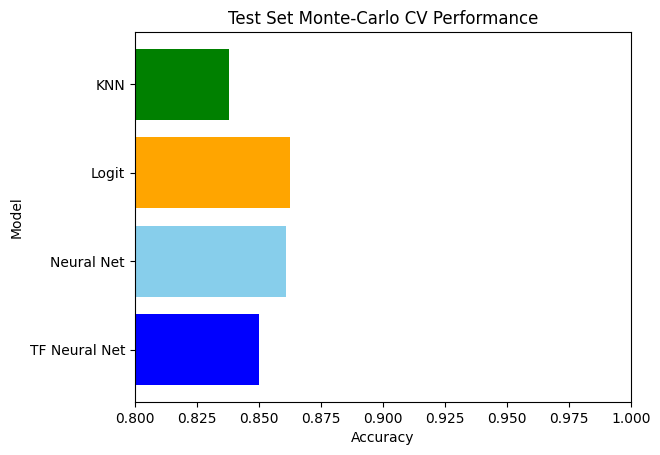

0.8501666666666668 0.8611111111111112 0.8626666666666668 0.8381111111111111


In [18]:
lgr_mccv = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i+200, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = jnp.array(scaler.fit_transform(X_train))
    X_test_scaled = jnp.array(scaler.transform(X_test))
    y_train, y_test = jnp.array(y_train.astype(float)), jnp.array(y_test.astype(float))
    lgr = LogisticRegression(max_iter=1000)
    lgr.fit(X_train_scaled, y_train)
    y_pred = lgr.predict(X_test_scaled)
    lgr_mccv.append(accuracy_score(y_pred, y_test))

knn_mccv = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i+200, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = jnp.array(scaler.fit_transform(X_train))
    X_test_scaled = jnp.array(scaler.transform(X_test))
    y_train, y_test = jnp.array(y_train.astype(float)), jnp.array(y_test.astype(float))
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    knn_mccv.append(accuracy_score(y_pred, y_test))


plt.barh(['TF Neural Net', 'Neural Net', 'Logit', 'KNN'],[np.mean(nntf_cc_mccv), np.mean(nn_cc_mccv), np.mean(lgr_mccv), np.mean(knn_mccv)], color=['blue', 'skyblue','orange','green'])
plt.title('Test Set Monte-Carlo CV Performance')
plt.xlim([0.8,1])
plt.xlabel('Accuracy')
plt.ylabel("Model")
plt.show()
plt.close()

print(np.mean(nntf_cc_mccv), np.mean(nn_cc_mccv), np.mean(lgr_mccv), np.mean(knn_mccv))
# print(np.mean)

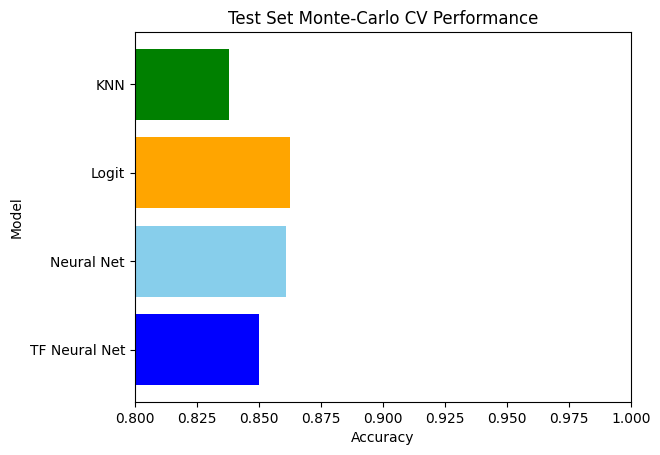

0.8501666666666668 0.8611111111111112 0.8626666666666668 0.8381111111111111
     Model  Accuracy
0    TF NN  0.866667
1    TF NN  0.883333
2    TF NN  0.811111
3    TF NN  0.855556
4    TF NN  0.888889
..     ...       ...
395    KNN  0.850000
396    KNN  0.811111
397    KNN  0.844444
398    KNN  0.855556
399    KNN  0.822222

[400 rows x 2 columns]
0     0.866667
1     0.883333
2     0.811111
3     0.855556
4     0.888889
        ...   
95    0.833333
96    0.822222
97    0.877778
98    0.905556
99    0.861111
Name: TF NN, Length: 100, dtype: float64
0     0.883333
1     0.883333
2     0.883333
3     0.861111
4     0.872222
        ...   
95    0.816667
96    0.855556
97    0.855556
98    0.894444
99    0.855556
Name: NN, Length: 100, dtype: float64
0     0.822222
1     0.833333
2     0.872222
3     0.900000
4     0.905556
        ...   
95    0.855556
96    0.844444
97    0.877778
98    0.850000
99    0.827778
Name: Logit, Length: 100, dtype: float64
0     0.800000
1     0.827778
2  

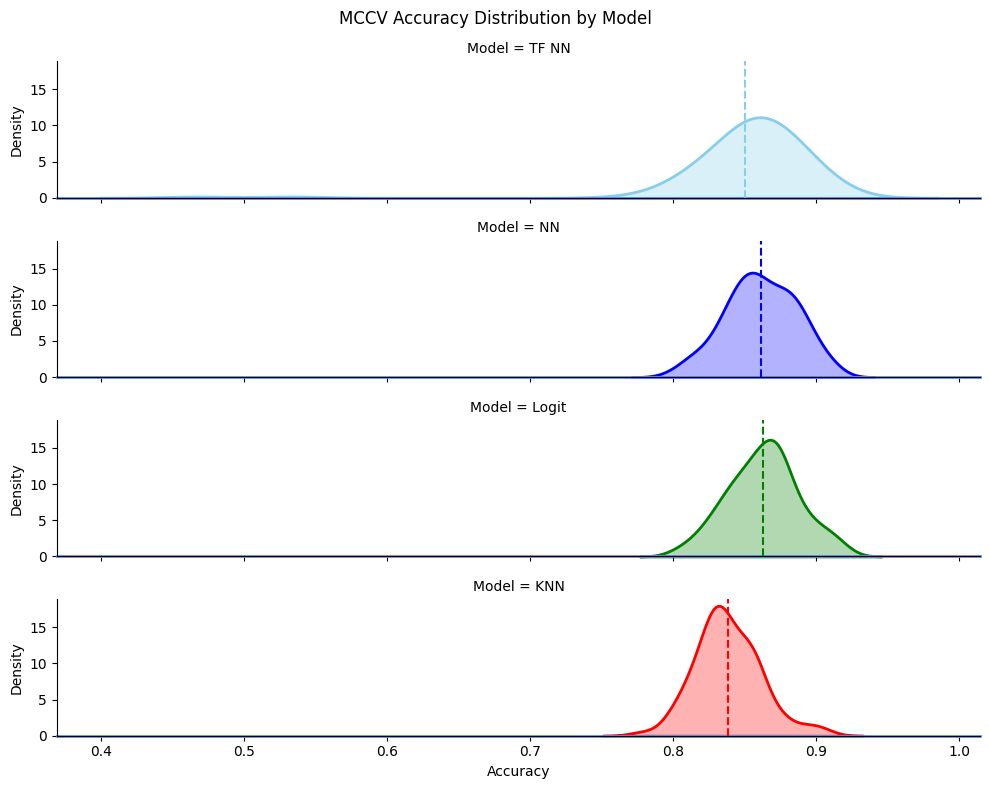

In [19]:
plt.barh(['TF Neural Net', 'Neural Net', 'Logit', 'KNN'],[np.mean(nntf_cc_mccv), np.mean(nn_cc_mccv), np.mean(lgr_mccv), np.mean(knn_mccv)], color=['blue', 'skyblue','orange','green'])
plt.title('Test Set Monte-Carlo CV Performance')
plt.xlim([0.8,1])
plt.xlabel('Accuracy')
plt.ylabel("Model")
plt.show()
plt.close()

print(np.mean(nntf_cc_mccv), np.mean(nn_cc_mccv), np.mean(lgr_mccv), np.mean(knn_mccv))
df = pd.DataFrame()
df['TF NN'] = nntf_cc_mccv
df['NN'] = nn_cc_mccv
df['Logit'] = lgr_mccv
df['KNN'] = knn_mccv

palette = {
    'TF NN':'skyblue',
    'NN': 'blue',
    'Logit': 'green',
    'KNN': 'red'
}

df_long = df.melt(var_name='Model', value_name='Accuracy')
print(df_long)
g = sns.FacetGrid(df_long, row='Model', hue='Model', palette=palette, aspect=5, height=2)
g.map(sns.kdeplot, 'Accuracy', clip_on=False, alpha=0.3, fill=True, lw=2)
g.map(plt.axhline, y=0, lw=2, color='cornflowerblue', clip_on=False)

c = 0
vals = list(palette.values())
for ax in g.axes.flat:
    print(df.iloc[:,c])
    ax.axvline(x=df.iloc[:,c].mean(), color=vals[c], linestyle='--', linewidth=1.5)
    c += 1

g.fig.suptitle("MCCV Accuracy Distribution by Model")
plt.tight_layout()

plt.show()

# g = sns.FacetGrid(df)
# g.map(sns.kdeplot,'TF NN', clip_on=False)
# g.map(sns.kdeplot,'NN', clip_on=False)
# g.map(sns.kdeplot,'Logit', clip_on=False)
# g.map(sns.kdeplot,'KNN', clip_on=False)

While the results are promising, it's important to test out different hyperparameters! In some instances, Neural Networks may be inferior computationally to other models that may perform just as good, if not better. Ultimately, the model used depends on the context, so rigorous comparison is always a must!